# Los Angeles County Map Project!

Having grown up in the low income area of Los Angeles County in Los Angeles, CA in the late 90's and early 2000's, I felt very inclined to come up with this project. We will be using Census 5-year ACS (American Community Survey) Data for the 2006-2010 and 2017-2021 Los Angeles County ACS estimates for the Median Household Income in the past 12 months, variable B19013. By the end of the project, we should be able to determine which areas are doing quite well and which areas are falling behind, and any shifts throughout time.

## Setup - Importing necessary python module libraries

In [1]:
import pandas as pd
import geopandas as gpd
import requests
from census import Census
import matplotlib.pyplot as plt
import seaborn as sns
import wget
import zipfile
import urllib
import contextily as cx

#### To request your own Census Api key and start querying for your own projects, fill out this form and you should receive your key within minutes: https://api.census.gov/data/key_signup.html

In [2]:
import getpass # secure way to provide private information - such as Census Data API key
key = getpass.getpass("Census Data API Key: ")

Census Data API Key: ········


In [3]:
c = Census(key)

## Getting and cleaning Data for Census 2006-2010 ACS estimates

In [4]:
state = '06' # FIPS code for CA
county = '037' # FIPS code for Los Angeles County

ca_census_data = c.acs5.state_county_tract(fields=('NAME','B19013_001E'), state_fips=state, county_fips=county,
                                           tract='*', year=2010)
ca_census_df = pd.DataFrame(ca_census_data) # creating DataFrame

# some census tracts have invalid data - let's remove them
ca_census_df = ca_census_df[ca_census_df['B19013_001E'] > 0]

In [5]:
print(ca_census_df.sort_values(by='B19013_001E').head(2))
print('Shape: {s}'.format(s=ca_census_df.shape))

                                                   NAME  B19013_001E state  \
2117  Census Tract 7011, Los Angeles County, California       2499.0    06   
199   Census Tract 2063, Los Angeles County, California       8647.0    06   

     county   tract  
2117    037  701100  
199     037  206300  
Shape: (2315, 5)


#### I will locate tract number for San Clemente Island and remove, as it does not appera in the later 2017-2021 LA County map - as you will see later on in this project.

In [6]:
ca_census_df[ca_census_df['tract']=='599100']

,NAME,B19013_001E,state,county,tract
1848,"Census Tract 5991, Los Angeles County, California",65000.0,06,037,599100


In [7]:
# dropping San Clemente Island index number
ca_census_df = ca_census_df.drop(1848)
print('Shape is: {c}'.format(c=ca_census_df.shape))

Shape is: (2314, 5)


In [8]:
# checking for missing values in the data
print(ca_census_df.isnull().sum())

NAME           0
B19013_001E    0
state          0
county         0
tract          0
dtype: int64


#### No missing values

In [9]:
# get shapefiles for the Los Angeles census tracts
ca_tract = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2010/gz_2010_06_140_00_500k.zip")
print(ca_tract.head(2))
print('Shape: {s}'.format(s=ca_tract.shape))

                 GEO_ID STATE COUNTY   TRACT     NAME   LSAD  CENSUSAREA  \
0  1400000US06001425103    06    001  425103  4251.03  Tract       0.341   
1  1400000US06001425104    06    001  425104  4251.04  Tract       0.415   

                                            geometry  
0  POLYGON ((-122.29236 37.84936, -122.28956 37.8...  
1  POLYGON ((-122.27860 37.82854, -122.27806 37.8...  
Shape: (8048, 8)


In [10]:
ca_tract = ca_tract.to_crs('NAD83')
print(ca_tract.head(2))
print('Shape: {s}'.format(s=ca_tract.shape))

                 GEO_ID STATE COUNTY   TRACT     NAME   LSAD  CENSUSAREA  \
0  1400000US06001425103    06    001  425103  4251.03  Tract       0.341   
1  1400000US06001425104    06    001  425104  4251.04  Tract       0.415   

                                            geometry  
0  POLYGON ((-122.29236 37.84936, -122.28956 37.8...  
1  POLYGON ((-122.27860 37.82854, -122.27806 37.8...  
Shape: (8048, 8)


In [11]:
print(ca_tract.crs)

EPSG:4269


In [12]:
# download water shapefiles for LA County
url = "https://www2.census.gov/geo/tiger/TIGER2010/AREAWATER/tl_2010_06037_areawater.zip"
    
# erasing water within the shapefile
urllib.request.urlretrieve(url, "tl_2010_06037_areawater.zip")
with zipfile.ZipFile("tl_2010_06037_areawater.zip") as zip_ref:
    zip_ref.extractall()

In [13]:
water = gpd.read_file("tl_2010_06037_areawater.shp")
ca_tract = ca_tract.overlay(water, how='difference') # water shapefiles will display over county map

In [14]:
print(ca_tract.shape)

(8047, 8)


In [15]:
print(ca_tract.head(2))

                 GEO_ID STATE COUNTY   TRACT     NAME   LSAD  CENSUSAREA  \
0  1400000US06001425103    06    001  425103  4251.03  Tract       0.341   
1  1400000US06001425104    06    001  425104  4251.04  Tract       0.415   

                                            geometry  
0  POLYGON ((-122.29236 37.84936, -122.28956 37.8...  
1  POLYGON ((-122.27860 37.82854, -122.27806 37.8...  


#### Combining shapefiles and cesus data

In [16]:
ca_data_geocoded=ca_tract.merge(ca_census_df,right_on=['state','county','tract'], left_on=['STATE','COUNTY','TRACT'])
print(ca_data_geocoded.head(1))
print(ca_data_geocoded.shape)

                 GEO_ID STATE COUNTY   TRACT   NAME_x   LSAD  CENSUSAREA  \
0  1400000US06037102104    06    037  102104  1021.04  Tract       0.641   

                                            geometry  \
0  POLYGON ((-118.35562 34.22003, -118.35427 34.2...   

                                              NAME_y  B19013_001E state  \
0  Census Tract 1021.04, Los Angeles County, Cali...      85492.0    06   

  county   tract  
0    037  102104  
(2314, 13)


#### Same size as ca_census_df, which means nothing was dropped when merging the two DataFrames

## Mapping

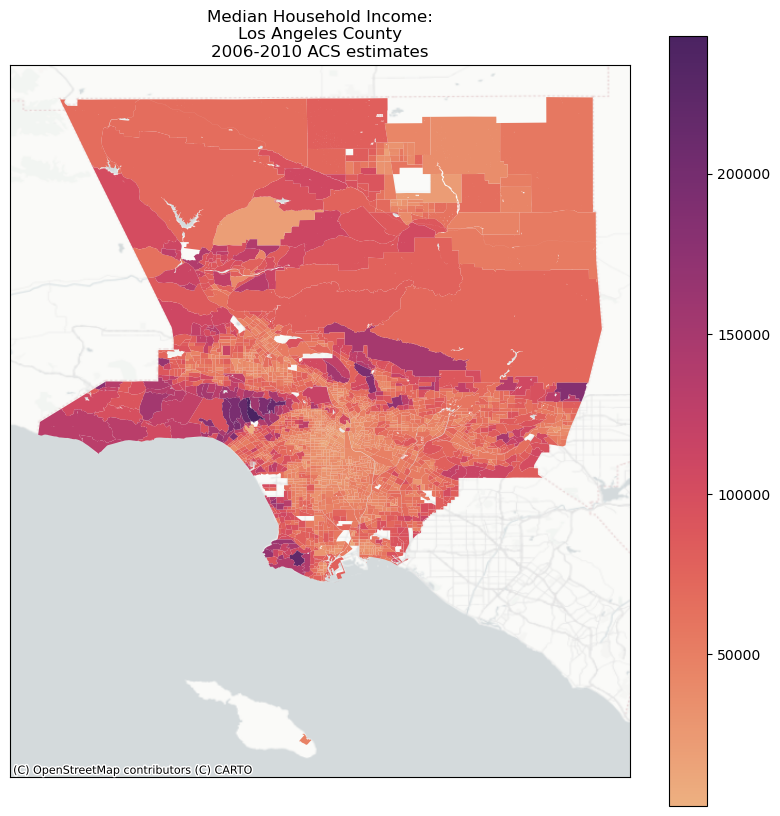

In [17]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
ca_data_geocoded.plot(column='B19013_001E', ax=ax, cmap=sns.color_palette('flare', as_cmap=True), legend=True)
cx.add_basemap(ax, crs=ca_data_geocoded.crs, source=cx.providers.CartoDB.PositronNoLabels)
plt.title("Median Household Income:\nLos Angeles County\n2006-2010 ACS estimates")
ax.axes.yaxis.set_visible(False)
ax.axes.xaxis.set_visible(False)
plt.show()

## Getting and cleaning Data for Census 2017-2021 ACS estimates

### We will take the same steps as above, just adapt it to the new data

In [18]:
state = '06' # FIPS code for CA
county = '037' # FIPS code for LA County

ca_census_data2 = c.acs5.state_county_tract(fields=('NAME','B19013_001E'), state_fips=state, county_fips=county,
                                           tract='*', year=2021)
ca_census_df2 = pd.DataFrame(ca_census_data2) # creating DataFrame

# some census tracts have invalid data - let's remove them
ca_census_df2 = ca_census_df2[ca_census_df2['B19013_001E'] > 0]

In [19]:
print(ca_census_df2.sort_values(by='B19013_001E').head(2))
print('Shape: {s}'.format(s=ca_census_df2.shape))

                                                  NAME  B19013_001E state  \
589  Census Tract 2063.02, Los Angeles County, Cali...       9201.0    06   
771  Census Tract 2247.02, Los Angeles County, Cali...      10783.0    06   

    county   tract  
589    037  206302  
771    037  224702  
Shape: (2451, 5)


In [20]:
# checking for missing values in the data
print(ca_census_df.isnull().sum())

NAME           0
B19013_001E    0
state          0
county         0
tract          0
dtype: int64


#### No missing values

In [21]:
# get shapefiles
ca_tract2 = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_06_tract_500k.zip")
print(ca_tract2.head(2))
print('Shape: {s}'.format(s=ca_tract2.shape))

  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME  \
0      06      037  294610  1400000US06037294610  06037294610  2946.10   
1      06      059  011402  1400000US06059011402  06059011402   114.02   

               NAMELSAD STUSPS          NAMELSADCO  STATE_NAME LSAD    ALAND  \
0  Census Tract 2946.10     CA  Los Angeles County  California   CT   823808   
1   Census Tract 114.02     CA       Orange County  California   CT  1136419   

   AWATER                                           geometry  
0       0  POLYGON ((-118.26331 33.79115, -118.25521 33.7...  
1       0  POLYGON ((-117.91371 33.88611, -117.91013 33.8...  
Shape: (9109, 14)


In [22]:
ca_tract2 = ca_tract2.to_crs('NAD83')
print(ca_tract2.head(2))
print('Shape: {s}'.format(s=ca_tract2.shape))

  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID     NAME  \
0      06      037  294610  1400000US06037294610  06037294610  2946.10   
1      06      059  011402  1400000US06059011402  06059011402   114.02   

               NAMELSAD STUSPS          NAMELSADCO  STATE_NAME LSAD    ALAND  \
0  Census Tract 2946.10     CA  Los Angeles County  California   CT   823808   
1   Census Tract 114.02     CA       Orange County  California   CT  1136419   

   AWATER                                           geometry  
0       0  POLYGON ((-118.26331 33.79115, -118.25521 33.7...  
1       0  POLYGON ((-117.91371 33.88611, -117.91013 33.8...  
Shape: (9109, 14)


In [23]:
# download water shapefiles for each county
url2 = "https://www2.census.gov/geo/tiger/TIGER2021/AREAWATER/tl_2021_06037_areawater.zip"
    
# erasing water within the shapefile
urllib.request.urlretrieve(url2, "tl_2021_06037_areawater.zip")
with zipfile.ZipFile("tl_2021_06037_areawater.zip") as zip_ref:
    zip_ref.extractall()

In [24]:
water2 = gpd.read_file("tl_2021_06037_areawater.shp")
ca_tract2 = ca_tract2.overlay(water2, how='difference')

#### Combining shapefiles and census data

In [25]:
ca_data_geocoded2=ca_tract2.merge(ca_census_df2,right_on=['state','county','tract'], left_on=['STATEFP','COUNTYFP',
                                                                                              'TRACTCE'])
print(ca_data_geocoded2.head(1))
print(ca_data_geocoded2.shape) # no data was dropped from ca_census_df2

  STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID   NAME_x  \
0      06      037  294610  1400000US06037294610  06037294610  2946.10   

               NAMELSAD STUSPS          NAMELSADCO  STATE_NAME LSAD   ALAND  \
0  Census Tract 2946.10     CA  Los Angeles County  California   CT  823808   

   AWATER                                           geometry  \
0       0  POLYGON ((-118.26331 33.79115, -118.25521 33.7...   

                                              NAME_y  B19013_001E state  \
0  Census Tract 2946.10, Los Angeles County, Cali...      63348.0    06   

  county   tract  
0    037  294610  
(2451, 19)


#### Same size as ca_census_df2, which means nothing was dropped when merging the two DataFrames

## Mapping

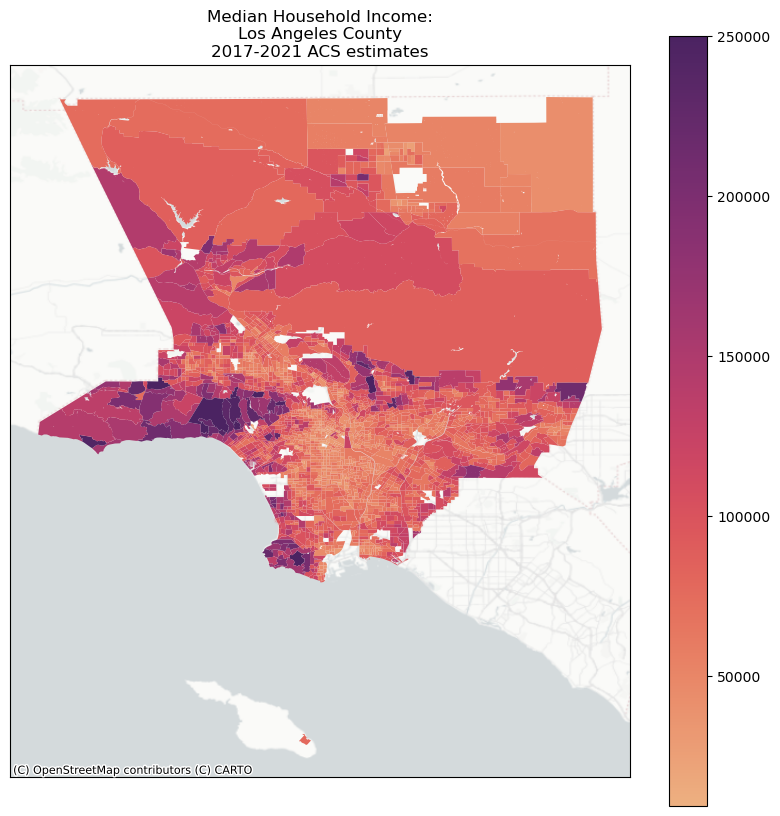

In [26]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,10)
ca_data_geocoded2.plot(column='B19013_001E', ax=ax, cmap=sns.color_palette('flare', as_cmap=True), legend=True)
cx.add_basemap(ax, crs=ca_data_geocoded2.crs, source=cx.providers.CartoDB.PositronNoLabels)
plt.title("Median Household Income:\nLos Angeles County\n2017-2021 ACS estimates")
ax.axes.yaxis.set_visible(False)
ax.axes.xaxis.set_visible(False)
plt.show()

## Side-by-Side Visual Comparison of the two Census 5-year ACS estimates

In [27]:
# figuring out min and max for both datasets to set limits on the plots below
vmin = ca_data_geocoded['B19013_001E'].min()
vmax = ca_data_geocoded['B19013_001E'].max()
vmin2 = ca_data_geocoded2['B19013_001E'].min()
vmax2 = ca_data_geocoded2['B19013_001E'].max()
print(vmin, vmax, vmin2, vmax2)

2499.0 242935.0 9201.0 250001.0


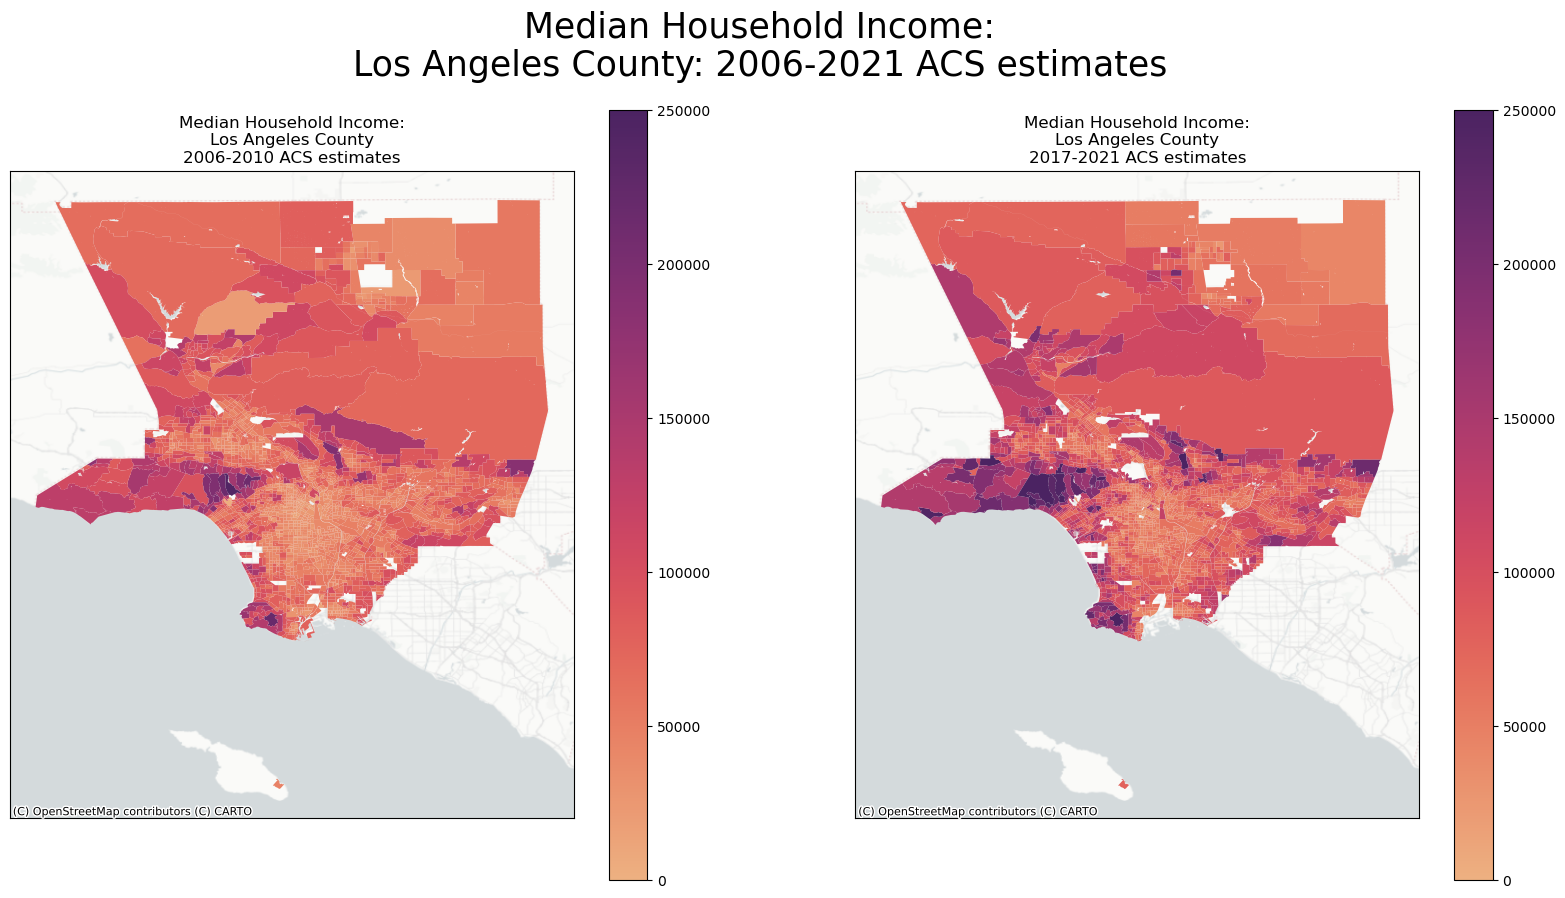

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(20,10)
ca_data_geocoded.plot(column='B19013_001E', ax=ax1, cmap=sns.color_palette('flare', as_cmap=True), legend=True
                      , vmin='0', vmax='250000')
cx.add_basemap(ax1, crs=ca_data_geocoded.crs, source=cx.providers.CartoDB.PositronNoLabels)
ax1.set_title("Median Household Income:\nLos Angeles County\n2006-2010 ACS estimates")
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ca_data_geocoded2.plot(column='B19013_001E', ax=ax2, cmap=sns.color_palette('flare', as_cmap=True), legend=True
                       , vmin='0', vmax='250000')
cx.add_basemap(ax2, crs=ca_data_geocoded2.crs, source=cx.providers.CartoDB.PositronNoLabels)
ax2.set_title("Median Household Income:\nLos Angeles County\n2017-2021 ACS estimates")
ax2.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
fig.suptitle('Median Household Income:\nLos Angeles County: 2006-2021 ACS estimates', fontsize=25)
plt.show()

## Conclusion

As we can see, areas towards the west-side are within the 200,000 and 250,000 median household income for the past 12 months, more affluent areas - This makes sense when you think about which cities are in the West side of Los Angeles County: West Hollywood, Beverly Hills, Calabasas. Focusing in more specifically on the area I grew up in (Central Los Angeles - Downtown Los Angeles), there seems to be some progress in median household income, but still very low, between 0 and 50,000.

### I hope you enjoyed my project, and get to working with census data and create your own projects!